# <h1><center><b>Machine Learning</b></center></h1>
<h3><center>Exercise 5</center></h3>

Your Name:  
<font color='red'>
ran wurembrand

</font>


____________

**Instructions:**
- Create a copy of this notebook and implement your code in it.
- Ensure you don't leave any cells or answers empty.
- Do not change the code we provided.
- After completing the assignment, download this **notebook** (with your code and all outputs!) named ***Ex5_Machine_Learning.ipynb***, and ***predictions.txt*** file, and submit them together in a zip file named ***ex5.zip*** to the [**"submit"**](https://submit.cs.biu.ac.il/cgi-bin/welcome.cgi) system under course number **"89-2511"**, group number **"01"** and assignment **"ex5_ML"**.
To Download the notebook go to **"File"** -> **"Download .ipynb"**.  
- Submit deadline: 19/07/2024 16:00

## Part 1 - Neural Network using NumPy **(37 points)**

In this part, we learn to:
1. Load and preprocess datasets.
2. Implement and train a neural network (multi-layer perceptron) for handwriting recognition using the MNIST dataset, with *numpy* as the only library (The use of libraries other than *numpy* and *fetch_openml* function is strictly prohibited in **Part 1** only).

### **Import useful packages**

In [1]:
import numpy as np
from sklearn.datasets import fetch_openml

### **Dataset (6 points)**


The **MNIST (Modified National Institute of Standards and Technology database)** dataset contains a training set of 60,000 images and a test set of 10,000 images of handwritten digits (10 digits). The handwritten digit images have been size-normalized and centered in a fixed size of 28x28 pixels.


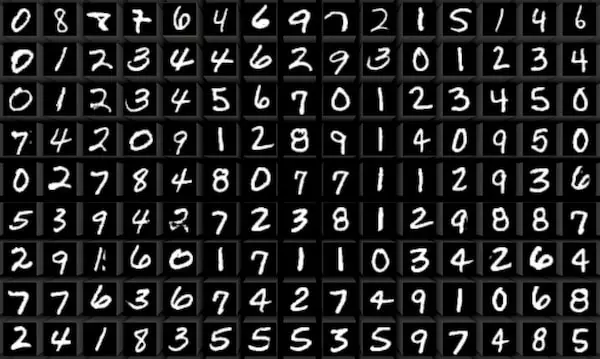

Download the MNIST dataset

In [2]:
X, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False, parser='auto')
print(X.shape, y.shape)


(70000, 784) (70000,)


Data normalization

In [3]:
## TODO: Normalize the dataset according to Min-Max normalization.
def min_max_norm(X):
    X_min = X.min(axis=0)
    X_max = X.max(axis=0)
    # Prevent division by zero by adding a small epsilon where the denominator would be zero
    return (X - X_min) / np.where((X_max - X_min) == 0, np.finfo(float).eps, (X_max - X_min))

X = min_max_norm(X)

Split the data into Train set (80%) and a Test set (20%)

In [4]:
# Calculate the number of training examples (80% of the dataset)
num_training_samples = int(len(X) * 0.8)

# Generate a random permutation of indices from 0 to the number of samples
indices = np.random.permutation(len(X))

# Assign the first 80% of the randomly permuted indices to the training set
train_indices = indices[:num_training_samples]

# Assign the remaining 20% of the indices to the test set
test_indices = indices[num_training_samples:]

# Slice the datasets to create the training and test sets
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]


### **Useful functions (7 points)**

Activation function - Sigmoid

In [5]:
def sigmoid(z):
    """The sigmoid activation function."""
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    """Derivative of the sigmoid function."""
    s = sigmoid(z)
    return s * (1 - s)


Softmax function

In [6]:
def softmax(z):
    """Softmax function implementation."""
    # Subtract the max for numerical stability
    exp_z = np.exp(z - np.max(z))
    return exp_z / exp_z.sum(axis=0, keepdims=True)

Loss function

In [7]:
# Negative Log Likelihood loss function for multiclass
# Receive y_pred, which is a (10,) vector containing probability predictions, and y_true,
# which is a one-hot (10,) vector with the value of 1 only at the correct class index and zeros elsewhere.
def nll_loss(y_pred, y_true):
  loss = -np.sum(y_true * np.log(y_pred), dtype=np.float64)
  return loss / y_pred.shape[0]

### **Multilayer Perceptron (24 points)**

Hyper-Parameters

In [8]:
# Input layer size - Each image in the MNIST dataset is 28x28 pixels, flattened into a 784-dimensional vector
input_layer = 784

# Hidden layer size - This is a hyperparameter that you can tune. A common starting point is a layer roughly
# between the size of the input layer and the output layer. You might start with 128, 256, or 512 neurons.
hidden_layer = 256  # Example: 256 neurons

# Output layer size - The MNIST dataset has 10 classes (digits 0 through 9), so you need 10 output neurons
output_layer = 10

# Learning rate - Controls the step size during gradient descent. Common starting values range from 0.001 to 0.01.
learning_rate = 0.01  # Example: 0.01

# Epochs - The number of times the entire training dataset is passed forward and backward through the neural network.
epochs = 10  # Example: 10 epochs


Multilayer Perceptron class with train and test functions.

In [9]:
class MultilayerPerceptron:
    def __init__(self, input_layer, hidden_layer, output_layer, learning_rate, epochs):
        # Initialize weights and biases with random values
        self.W1 = np.random.randn(hidden_layer, input_layer) * 0.01
        self.b1 = np.zeros((hidden_layer, 1))
        self.W2 = np.random.randn(output_layer, hidden_layer) * 0.01
        self.b2 = np.zeros((output_layer, 1))

        # Hyperparameters
        self.learning_rate = learning_rate
        self.epochs = epochs

    def forward(self, X):
        Z1 = np.dot(self.W1, X) + self.b1
        A1 = sigmoid(Z1)
        Z2 = np.dot(self.W2, A1) + self.b2
        A2 = softmax(Z2)
        return Z1, A1, Z2, A2

    def backward(self, X, Y, Z1, A1, Z2, A2):
        m = Y.shape[1]  # number of examples

        dZ2 = A2 - Y
        dW2 = np.dot(dZ2, A1.T) / m
        db2 = np.sum(dZ2, axis=1, keepdims=True) / m

        dA1 = np.dot(self.W2.T, dZ2)
        dZ1 = dA1 * sigmoid_derivative(Z1)
        dW1 = np.dot(dZ1, X.T) / m
        db1 = np.sum(dZ1, axis=1, keepdims=True) / m

        # Update parameters
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train(self, X_train, y_train):
        train_size = X_train.shape[0]

        for epoch in range(self.epochs):
            total_epoch_loss = 0
            for i in range(train_size):
                x_i = X_train[i].reshape(-1, 1)
                y_i = np.zeros((10, 1))
                y_i[int(y_train[i]), 0] = 1

                Z1, A1, Z2, A2 = self.forward(x_i)
                loss = nll_loss(A2, y_i)
                total_epoch_loss += loss

                self.backward(x_i, y_i, Z1, A1, Z2, A2)

            print(f"Epoch {epoch + 1}/{self.epochs}, Average Loss: {total_epoch_loss / train_size}")

    def test(self, X_test, y_test):
        test_size = X_test.shape[0]
        true_predictions = 0

        for i in range(test_size):
            x_i = X_test[i].reshape(-1, 1)
            Z1, A1, Z2, A2 = self.forward(x_i)
            predicted_class = np.argmax(A2)
            print("Predicted Class:", predicted_class, "True Class:", y_test[i])  # Debugging line
            print(f"Data types -> Predicted: {type(predicted_class)}, True: {type(y_test[i])}")  # Check data types
            if int(predicted_class) == int(y_test[i]):
                true_predictions += 1

        accuracy = true_predictions / test_size
        print(f"Accuracy: {accuracy:.2f}")

        accuracy = true_predictions / test_size
        print('true prediction is: ', true_predictions)
        print('test size is: ', test_size)
        print(f"Accuracy: {accuracy:.2f}")


#### **Train**

In [10]:
mlp = MultilayerPerceptron(
    input_layer=784,    # Input layer size: each image is 28x28 pixels, flattened
    hidden_layer=128,   # Hidden layer size: can be tuned, example is 256 neurons
    output_layer=10,    # Output layer size: corresponding to 10 digits (0-9)
    learning_rate=0.01, # Learning rate for the gradient descent optimization
    epochs=10            # Number of times the entire dataset is passed through the network
)

# Train your model - ensure that X_train and y_train are properly defined and preprocessed
mlp.train(X_train, y_train)

KeyboardInterrupt: 

#### **Test**

Accuracy should be more than **0.8** !

In [ ]:
mlp.test(X_test, y_test)

## Part 2 - Neural Network in PyTorch **(63 points)**

____________

In this exercise, we will learn to:
1. Load and preprocess datasets using Pytorch.
2. Implement and train a neural network (multi-layer perceptron) for Fashion classification (Fashion-MNIST dataset), using Pytorch.
3. Implement and train a Convolutional Neural Network (CNN) on Fashion-MNIST.

### **1. Setup**
Before running code on Colab:
- Navigate to "Runtime" -> "Change runtime type", and ensure you select "GPU" for Hardware accelerator.
- Verify your Python version at the command line by executing '!python --version'. It should default to Python 3.6 or higher.
- Upload the **[FashionMNIST_test.pth](https://drive.google.com/file/d/1FeOaoRU-tkhOiKzsK_UZNwbNPaRqaDVu/view?usp=sharing)** file to your Drive (e.g "machine_learning/assignments/assignment5") and mount that data to the machine. See the next cell below. Although it is possible to upload files to the local disk of Colab machines, note that such files will be deleted when the machine is restarted.

In [11]:
# check python version
!python --version

Python 3.10.12


In [12]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the code and datasets.
# Recommended path: 'machine_learning/assignments/assignment5/'
FOLDERNAME = 'machine_learning/assignments/'
ASSIGNMENTNAME = 'assignment5'

%cd drive/My\ Drive
%cp -r $FOLDERNAME/$ASSIGNMENTNAME ../../
%cd ../../

Mounted at /content/drive
/content/drive/My Drive
/content


### **2. Dataset (4 points)**

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes - **'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'**.

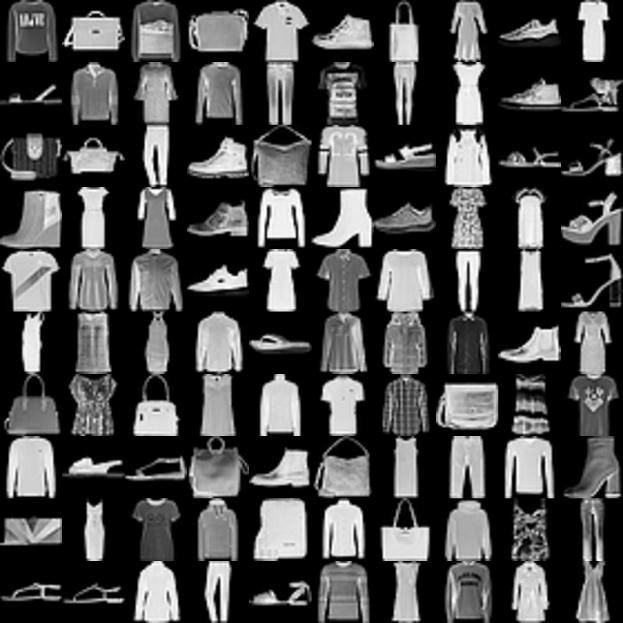

Let's visualize the data before working with it.  
1. We can use the "torchvision" package to download the trainset. Set ```transform``` as to be the transform function below (It normalizes each image) and ```train=True```.
2. We use torch.utils.data.DataLoader to load the data. Set ```batch_size=64```.

In [13]:
# load packages
import torch
import numpy as np
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt

In [14]:
data_path = "./FashionMNIST_data"

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the data
mnist_data = datasets.FashionMNIST(data_path, download=True, train=True, transform=transform)
mnist_dataloader = torch.utils.data.DataLoader(mnist_data, batch_size=64, shuffle=True)

100%|██████████| 26421880/26421880 [00:01<00:00, 18918296.93it/s]


Extracting ./FashionMNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 309423.00it/s]


Extracting ./FashionMNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5508527.01it/s]


Extracting ./FashionMNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18662296.45it/s]

Extracting ./FashionMNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST_data/FashionMNIST/raw



Using the ```mnist_data``` (dataset) and ```mnist_dataloader``` (batch dataloader):
1. Print the number of samples in the whole dataset.
2. Print the number of samples in a single batch.
3. Print the shape of images in the data.
4. Print the number of labels in the dataset (targets).
5. Plot 3 random images using matplotlib (```plt.imshow```) and print their labels.

Total number of samples in the dataset: 60000
Number of samples in a single batch: 64
Shape of images in each batch: torch.Size([64, 1, 28, 28])
Number of unique labels in the dataset: 10


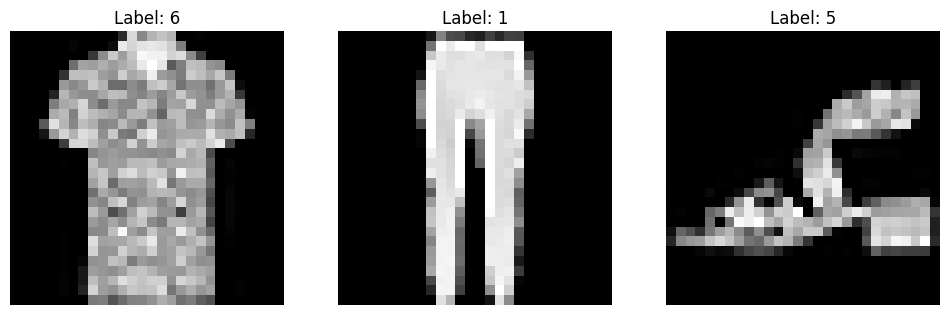

In [15]:
dataiter = iter(mnist_dataloader)
batch_images, batch_labels = next(dataiter)

# TODO: 1. Print the number of samples in the whole dataset.
print(f"Total number of samples in the dataset: {len(mnist_data)}")

# TODO: 2. Print the number of samples in a single batch.
print(f"Number of samples in a single batch: {batch_labels.size(0)}")

# TODO: 3. Print the shape of images in the data (image dimensions).
print(f"Shape of images in each batch: {batch_images.size()}")

# TODO: 4. Print the number of labels in the whole dataset (using the targets in the dataloader.dataset).
print(f"Number of unique labels in the dataset: {len(np.unique(mnist_data.targets.numpy()))}")

# Plot 3 random images and print their labels
indices = np.random.choice(batch_images.size(0), 3, replace=False)
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for idx, ax in zip(indices, axes):
    ax.imshow(batch_images[idx].squeeze(), cmap='gray')
    ax.title.set_text(f"Label: {batch_labels[idx].item()}")
    ax.axis('off')
plt.show()

Labels: ['Ankle boot', 'Sandal', 'Bag']


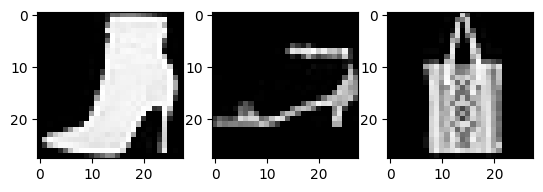

In [16]:
# 5. plot three images and print their labels
idx = np.random.choice(range(64),3) # three random indices
plt.subplot(1,3,1)
plt.imshow(batch_images[idx[0]].numpy().squeeze(), cmap='Greys_r')
plt.subplot(1,3,2)
plt.imshow(batch_images[idx[1]].numpy().squeeze(), cmap='Greys_r')
plt.subplot(1,3,3)
plt.imshow(batch_images[idx[2]].numpy().squeeze(), cmap='Greys_r')

# Define the label names array, where each label corresponds to its class, which is also its index
label_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

print("Labels:", [label_names[i] for i in batch_labels[idx]])

### **3. Neural Network - Architecture (11 points)**

In the next section, we are going to implement a neural network with pytorch that gets Fashion-MNIST images and recognizes the digit in them.  

Network Architecture (see image below): **784 input units**, a hidden layer with **128 units** and a **ReLU activation**, then a hidden layer with **64 units** and a **ReLU activation**, and finally an **output layer** with a **log-softmax activation**.

Note: Since simple neural networks get vectors as inputs, and not images (unlike CNNs), we should flatten the data. Each sample with shape (28,28) becomes (784,). That is why the input layer has 784 units.  


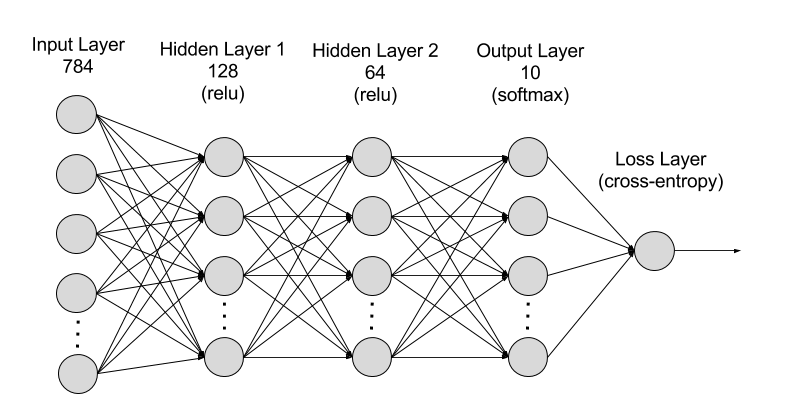

Complete the code below: The constructor (```__init___```) should contain defenitions of layers like ```Linear``` or ```Relu```. The ```forward``` function should contain the logic between the layers declared in the constructor.  

For this section, as well as the next section, you can follow online tutorials (like **[this tutorial](https://adventuresinmachinelearning.com/pytorch-tutorial-deep-learning/)** or **[this one](https://www.marktechpost.com/2019/11/09/create-a-neural-network-with-pytorch/)**) to understand how to implement Neural Networks with Pytorch.

In [17]:
from torch import nn, optim
import torch.nn.functional as F

In [18]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        # Define the layers of the network
        # Input layer to first hidden layer
        self.hidden1 = nn.Linear(784, 128)
        # First hidden layer to second hidden layer
        self.hidden2 = nn.Linear(128, 64)
        # Second hidden layer to output layer
        self.output = nn.Linear(64, 10)

    def forward(self, x):
        # Flatten the input tensor to [batch_size, 784]
        x = x.view(x.shape[0], -1)

        # Forward pass through the first hidden layer with ReLU activation
        x = F.relu(self.hidden1(x))
        # Forward pass through the second hidden layer with ReLU activation
        x = F.relu(self.hidden2(x))
        # Output layer with log-softmax activation
        # dim=1 tells the softmax function that the calculations should be done across the features and not the batch dimension
        x = F.log_softmax(self.output(x), dim=1)
        return x

model = NeuralNetwork()
model

NeuralNetwork(
  (hidden1): Linear(in_features=784, out_features=128, bias=True)
  (hidden2): Linear(in_features=128, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
)

Now that we have a network, let's see what happens when we pass in an image.  
We'll choose a random image and pass it through the network. It should return a prediction - confidences for each class. The class with the highest confidence is the prediction of the model for that image.   
We visualize the results using the ```view_classify``` function below.

In [19]:
def view_classify(img, ps, version="MNIST"):
    '''
    Function for viewing an image and its predicted classes.
    img - the input image to the network
    ps - the class confidences (network output)
    '''
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6, 9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze(), cmap='Greys_r')
    ax1.axis('off')

    # Setting the y-ticks for the bar chart
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))  # Numeric y-ticks for positioning

    # Using set_yticklabels to assign string labels to y-ticks
    if version == "MNIST":
        ax2.set_yticklabels(label_names)

    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    plt.show()

In [20]:
def random_prediction_example(data_loader, model):
  '''
  The function sample an image from the data, pass it through the model (inference)
  and show the prediction visually. It returns the predictions confidences.
  '''
  # take a batch and randomly pick an image
  dataiter = iter(data_loader)
  images, labels = next(dataiter)
  images.resize_(64, 1, 784)
  img = images[0]

  # Forward pass through the network
  # we use torch.no_grad() for faster inference and to avoid gradients from
  # moving through the network.
  with torch.no_grad():
      ps = model(img)
      # the network outputs log-probabilities, so take exponential for probabilities
      ps = torch.exp(ps)

  # visualize image and prediction
  view_classify(img.view(1, 28, 28), ps)
  return ps

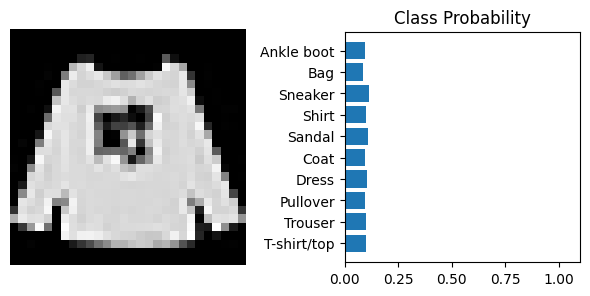

In [21]:
# you can run this cell multiple times for different images
preds_conf = random_prediction_example(mnist_dataloader, model)

Print the prediction

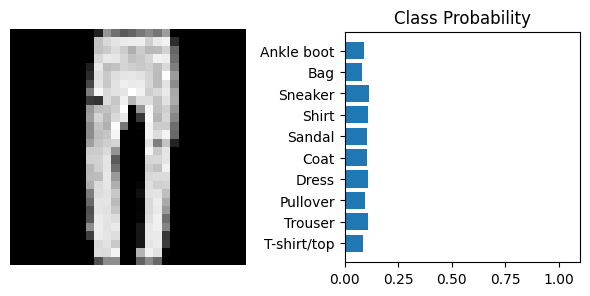

The predicted class is: 7


In [22]:
# Run the function to get predictions confidences
preds_conf = random_prediction_example(mnist_dataloader, model)

# TODO: Print the prediction of the network for that sample (preds_conf)
predicted_class = torch.argmax(preds_conf)  # Get the index of the max log-probability
print(f"The predicted class is: {predicted_class.item()}")


### **4. Neural Network - Training (35 points)**

We can now train and evaluate our network.
1. Split the dataset into a training set and a validation set. Train-set size: 80% of the total data. Val-set size: the rest 20%.
2. Create a dataloader for each set (```train_loader``` and ```val_loader```, see Section 2 for examples).
3. Choose hyperparameters (for now we choose ```learning_rate=0.005``` and ```num_epochs=5```).
4. Use SGD (Stochastic Gradient Descent) as the optimizer.
5. Since it is a multi-class classification task, use "negative log-likelihood loss" as the loss criterion.
6. Train your model on the train-set and evaluate it on the validation-set.
7. During training, for each epoch, track the training loss and validation loss.

In [23]:
from torch.utils import data

In [24]:
# TODO: 1. split trainset into train and validation (use torch.utils.data.random_split())
train_size = int(0.8 * len(mnist_data))
val_size = len(mnist_data) - train_size
train_dataset, val_dataset = data.random_split(mnist_data, [train_size, val_size])


# TODO: 2.1. create data loader for the trainset (batch_size=64, shuffle=True)
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)



# TODO: 2.2. create data loader for the valset (batch_size=64, shuffle=False)
val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [25]:
# 3. set hyper parameters
learning_rate = 0.005
nepochs = 5

In [26]:
model = NeuralNetwork()
# TODO: 4. create sgd optimizer. It should optimize our model parameters with
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# TODO: 5. create a criterion object. It should be negative log-likelihood loss since the task
criterion = nn.NLLLoss()

In [27]:
# 6.1. Train the model. (Fill empty code blocks)
def train_model(model, optimizer, criterion,
                nepochs, train_loader, val_loader, is_image_input = False):
  '''
  Train a pytorch model and evaluate it every epoch.
  Params:
  model - a pytorch model to train
  optimizer - an optimizer
  criterion - the criterion (loss function)
  nepochs - number of training epochs
  train_loader - dataloader for the trainset
  val_loader - dataloader for the valset
  is_image_input (default False) - If false, flatten 2d images into a 1d array.
                                Should be True for Neural Networks
                                but False for Convolutional Neural Networks.
  '''
  train_losses, val_losses = [], []
  for e in range(nepochs):
      running_loss = 0
      running_val_loss = 0
      for images, labels in train_loader:
          if is_image_input:
            # Flatten Fashion-MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)

          # Training pass
          model.train() # set model in train mode

          optimizer.zero_grad()  # Zero the gradients before running the backward pass.
          output = model(images)  # Forward pass: compute the predicted outputs by passing inputs to the model
          loss = criterion(output, labels)  # Calculate the loss
          loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
          optimizer.step()  # Perform a single optimization step (parameter update)

          running_loss += loss.item()  # Add up the loss value to the total for this epoch
      else:
          val_loss = 0
          # 6.2 Evalaute model on validation at the end of each epoch.
          with torch.no_grad():
              for images, labels in val_loader:
                  if is_image_input:
                    # Flatten Fashion-MNIST images into a 784 long vector
                    images = images.view(images.shape[0], -1)
                  model.eval() # set model in evaluation mode

                  output = model(images)  # Forward pass to get the output from the model
                  val_loss = criterion(output, labels)  # Compute the validation loss
                  running_val_loss += val_loss.item()

          # 7. track train loss and validation loss
          train_losses.append(running_loss/len(train_loader))
          val_losses.append(running_val_loss/len(val_loader))

          print("Epoch: {}/{}.. ".format(e+1, nepochs),
                "Training Loss: {:.3f}.. ".format(running_loss/len(train_loader)),
                "Validation Loss: {:.3f}.. ".format(running_val_loss/len(val_loader)))
  return train_losses, val_losses

In [28]:
  # 6.1. Train the model.
  ## NOTE: Do not run this cell continuously without running the two cells above!
  ##       Otherwise, you might train a model you have already trained.
  ##       So make sure to run the two cells above (to first initialize the model
  ##       and optimizer), every time, before running this cell!
train_losses, val_losses = train_model(model, optimizer, criterion, nepochs,
                                       train_loader, val_loader, is_image_input=True)

Epoch: 1/5..  Training Loss: 1.453..  Validation Loss: 0.858.. 
Epoch: 2/5..  Training Loss: 0.733..  Validation Loss: 0.655.. 
Epoch: 3/5..  Training Loss: 0.613..  Validation Loss: 0.579.. 
Epoch: 4/5..  Training Loss: 0.555..  Validation Loss: 0.540.. 
Epoch: 5/5..  Training Loss: 0.517..  Validation Loss: 0.508.. 


If you implemented everything correctly, you should see the training loss drop with each epoch.

8. Plot train loss and validation loss as a function of epoch. **On the same graph!**

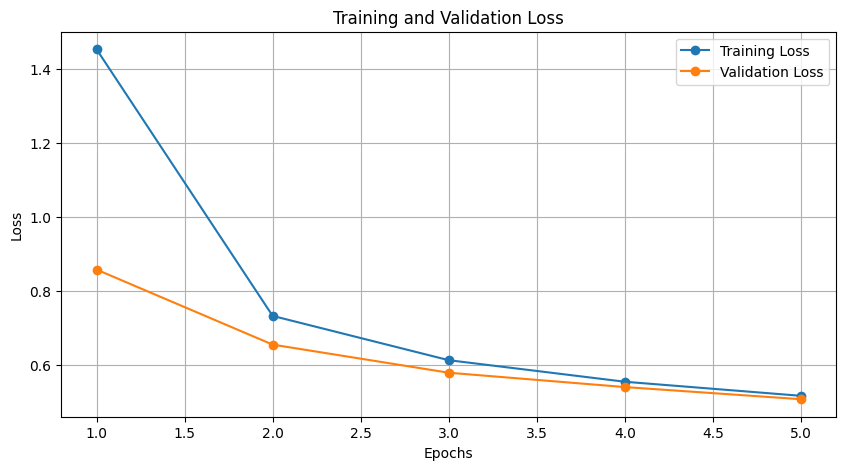

In [29]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

With the network trained, we can check out it's predictions:

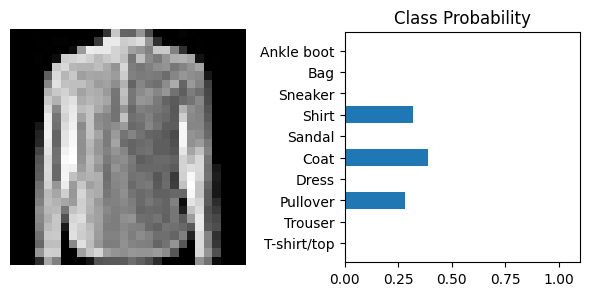

In [30]:
# you can run this cell multiple times for different images
ps = random_prediction_example(mnist_dataloader, model)

Calculate the model's accuracy on the validation-set.

In [31]:
def evaluate_model(model, val_loader, is_image_input=False):
  '''
  Evaluate a model on the given dataloader.
  Params:
  model - a pytorch model to train
  val_loader - dataloader for the valset
  is_image_input (default False) - If false, flatten 2d images into a 1d array.
                                   Should be True for Neural Networks
                                   but False for Convolutional Neural Networks.
  '''
  validation_accuracy = 0
  with torch.no_grad():
      model.eval()
      for images, labels in val_loader:
          if is_image_input:
            # flatten Fashion-MNIST images into a 784 long vector
            images = images.view(images.shape[0], -1)
          # forward pass
          test_output = model(images)
          ps = torch.exp(test_output)
          top_p, top_class = ps.topk(1, dim=1)
          # count correct predictions
          equals = top_class == labels.view(*top_class.shape)
          validation_accuracy += torch.sum(equals.type(torch.FloatTensor))
  res = validation_accuracy/len(val_loader.dataset)
  return res

In [32]:
print(f"Validation accuracy: {evaluate_model(model, val_loader, is_image_input=True)}")

Validation accuracy: 0.824833333492279


### **5. Convolutional Neural Networks (13 points)**

In this section, we are going to implement a convolutional neural network (CNN) and train it on the mnist dataset. It will be very similar to what you did in the previous sections but now we use new layers like ```convolution```and ```pooling```.  

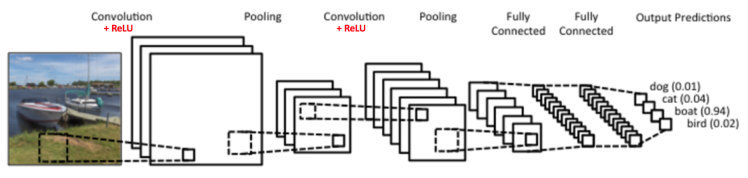

Reminder:  
Go over this **[article](https://cs231n.github.io/convolutional-networks/)** to better understand convolutional neural networks.

- **Convolutional operation:** A “filter”, also called a “kernel”, is passed over the image, viewing a few pixels at a time (for example, 3X3 or 5X5). The convolution operation is a dot product of the original pixel values with weights defined in the filter. The results are summed up into one number that represents all the pixels the filter observed.

- **Pooling:** “Pooling” is the process of further downsampling and reducing the size of the matrix. A filter is passed over the results of the previous layer and selects one number out of each group of values (typically the maximum, this is called max pooling). This allows the network to train much faster, focusing on the most important information in each feature of the image. By sliding the window along the image, we compute the mean or the max of the portion of the image inside the window in case of MeanPooling or MaxPooling.

- **Stride:** The number of pixels to pass at a time when sliding the convolutional kernel.

- **Padding:** To preserve exactly the size of the input image, it is useful to add zero padding on the border of the image.

**How do we compute the output size of a convolutional layer?**

input:
- An image of dimensions $W_{in}×H_{in}$.
- A filter of dimensions $K \times K$.
- Stride $S$
- padding $P$

$$W_{out} = \left\lfloor\frac{W_{in} - F + 2P}{S}\right\rfloor + 1$$
<br>
$$H_{out} = \left\lfloor\frac{H_{in} - F + 2P}{S}\right\rfloor + 1$$

**Q1:** Given an image with shape [1,28,28], what will be the shape of the output of a convolution layer with 10 5x5 kernels (filters), with stride of 1, and without padding?

**A1:**
<font color='red'>
YOUR ANSWER WITH EXPLANATIONS HERE! (3 points)
</font>

**Q2:** We would like our convolution layer to output a volume with the same shape as the input image. So input_shape and output_shape will be [1,28,28]. What should be the padding (assume 5x5 filter and stride of 1)?

**A2:**
<font color='red'>
YOUR ANSWER WITH EXPLANATIONS HERE! (2 points)
</font>

**Q3:** Consider an input image with shape [1, 28, 28]. You apply two consecutive convolution layers. The first convolution layer uses 20 filters, each of size 3x3, with a stride of 1 and no padding. The second convolution layer uses 15 filters, each of size 3x3, with a stride of 3 and padding of 2. What will be the shape of the output after these two convolution layers?

**A3:**
<font color='red'>
YOUR ANSWER WITH EXPLANATIONS HERE! (4 points)
</font>

Let's create a simple Convolutional neural network.
The architecture:  
**Conv layer** (10 5x5 Kernels) -> **Max Pooling** (2x2 kernel) -> **Relu** -> **Conv layer** (20 5x5 Kernels) -> **Max Pooling** (2x2 kernel) -> **Relu** -> **Hidden layer** (320 units) -> **Relu** -> **Hidden layer** (50 units) -> **Output layer** (10 outputs).

In [33]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.conv1(x) # conv 1
        x = F.max_pool2d(x, 2) # max pooling 1
        x = F.relu(x) # relu
        x = self.conv2(x) # conv 2
        x = F.max_pool2d((x), 2) # max pooling 2
        x = F.relu(x) # relu
        x = x.view(-1, 320) # flatten input
        x = self.fc1(x) # hidden layer 1
        x = F.relu(x) # relu
        x = self.fc2(x) # hidden layer 2
        return F.log_softmax(x, dim=1) #output

cnn_model = ConvolutionalNet()
print(cnn_model)

ConvolutionalNet(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


We can now train the model on the train set.

In [34]:
# set hyperparameters
cnn_nepochs = 3
cnn_learning_rate = 0.03

In [35]:
# train the conv model
cnn_model = ConvolutionalNet()
# create sgd optimizer
cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=cnn_learning_rate)
# create negative log likelihood loos
cnn_criterion = nn.NLLLoss()

train_losses, val_losses = train_model(cnn_model, cnn_optimizer, cnn_criterion,
                                       cnn_nepochs, train_loader, val_loader, is_image_input=False)

Epoch: 1/3..  Training Loss: 0.972..  Validation Loss: 0.667.. 
Epoch: 2/3..  Training Loss: 0.574..  Validation Loss: 0.568.. 
Epoch: 3/3..  Training Loss: 0.486..  Validation Loss: 0.455.. 


In [36]:
# evaluate on the validation set
print(f"Validation accuracy: {evaluate_model(cnn_model, val_loader, is_image_input=False)}")

Validation accuracy: 0.8289166688919067


You should probably see that our CNN performs better on the validation set compared to the simple neural network (within 3 epochs only!) :)

___________

Now it's your turn: Use the code above and create a convolutional neural network that achieves the best accuracy on the validation set.
Note that you must use only the Fashion-MNIST training set as we did earlier:
```mnist_data = datasets.FashionMNIST(data_path, download=True, train=True, transform=transform)```

**Using any other or additional data from the test set will result in point deductions (without any bonus)!**

You should consider changing (change at least 4 things):  
1. Network architecture:
  - Number of convolutional layers
  - Number of kernels (filters) for each convolutional layer
  - Size of each kernel on each layer
  - Number of hidden layers (fully connected)
  - Number of units for each hidden layer
  - Usage of layers like BatchNormalization and Dropout.
  - Usage of max pooling (or maybe other pooling strategies)

2. Training hyperparameters:
  - Learning rate
  - Optimizer (SGD with momentum, adam, etc)
  - Number of epochs

To get full points in this part: make sure you implement the model architecture correctly, train the model properly, use the optimizer effectively, and ensure your validation accuracy is greater than 80%. **(4 points for this part)**

In [37]:
## TODO: Prepocess
######################
### YOUR CODE HERE ###
######################
data_path = "./FashionMNIST_data_CNN"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download and load the data
mnist_data = datasets.FashionMNIST(data_path, download=True, train=True, transform=transform)
mnist_data = datasets.FashionMNIST(data_path, download=True, train=True, transform=transform)
train_size = int(0.8 * len(mnist_data))
val_size = len(mnist_data) - train_size
train_dataset, val_dataset = data.random_split(mnist_data, [train_size, val_size])
train_loader = data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=64, shuffle=False)

100%|██████████| 26421880/26421880 [00:02<00:00, 13101891.99it/s]


Extracting ./FashionMNIST_data_CNN/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST_data_CNN/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 299194.18it/s]


Extracting ./FashionMNIST_data_CNN/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST_data_CNN/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5550775.89it/s] 


Extracting ./FashionMNIST_data_CNN/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST_data_CNN/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 19505218.60it/s]


Extracting ./FashionMNIST_data_CNN/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST_data_CNN/FashionMNIST/raw



In [50]:
class ConvolutionalNet(nn.Module):
    def __init__(self):
        super(ConvolutionalNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        if x.dim() == 2:  # If input is flattened, reshape it.
            x = x.view(-1, 1, 28, 28)  # Reshape from [N, 784] to [N, C, H, W]
        x = self.conv1(x)  # Conv layer 1
        x = F.max_pool2d(x, 2)  # Max pooling 1
        x = F.relu(x)  # Relu activation
        x = self.conv2(x)  # Conv layer 2
        x = F.max_pool2d(x, 2)  # Max pooling 2
        x = F.relu(x)  # Relu activation
        x = x.view(-1, 320)  # Flatten the output for the dense layer
        x = self.fc1(x)  # Hidden layer 1
        x = F.relu(x)  # Relu activation
        x = self.fc2(x)  # Output layer
        return F.log_softmax(x, dim=1)


def train_and_save_best_model(model, optimizer, criterion, nepochs, train_loader, val_loader):
    best_accuracy = 0.0
    best_model = None

    for epoch in range(nepochs):
        model.train()
        for images, labels in train_loader:
            if images.ndim != 4:  # Check if images need reshaping
                raise ValueError("Images must be in [N, C, H, W] format")
            optimizer.zero_grad()
            outputs = model(images)  # Ensure images are not flattened
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        validation_accuracy = evaluate_model(model, val_loader, is_image_input=True)
        print(f"Epoch {epoch+1}: Validation Accuracy = {validation_accuracy:.4f}")

        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            best_model = model
            print(f"New best model saved with accuracy: {validation_accuracy:.4f}")

    return best_model

cnn_model = ConvolutionalNet()
cnn_optimizer = optim.SGD(cnn_model.parameters(), lr=0.05)
cnn_criterion = nn.NLLLoss()
cnn_nepochs = 12


In [53]:
def train_and_save_best_model(model, optimizer, criterion, nepochs, train_loader, val_loader):
    best_accuracy = 0.0
    best_model = None
    for epoch in range(nepochs):
        model.train()
        for images, labels in train_loader:
            # print(f"Shape of images before model.forward(): {images.shape}")  # Debugging line
            if images.shape[1] != 1:  # Ensure images have one channel
                raise ValueError(f"Incorrect shape! Expected channel dimension to be 1, but got {images.shape[1]}")

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        validation_accuracy = evaluate_model(model, val_loader, is_image_input=True)
        print(f"Epoch {epoch+1}: Validation Accuracy = {validation_accuracy:.4f}")

        if validation_accuracy > best_accuracy:
            best_accuracy = validation_accuracy
            best_model = model

    return best_model

best_model = train_and_save_best_model(cnn_model, cnn_optimizer, cnn_criterion, cnn_nepochs, train_loader, val_loader)
if best_model:
    validation_accuracy = evaluate_model(best_model, val_loader, is_image_input=True)
    print(f"Validation accuracy of the best model: {validation_accuracy:.4f}")
else:
    print("No best model was saved. Check training and validation processes.")

Epoch 1: Validation Accuracy = 0.9018
Epoch 2: Validation Accuracy = 0.9017
Epoch 3: Validation Accuracy = 0.9042
Epoch 4: Validation Accuracy = 0.9049
Epoch 5: Validation Accuracy = 0.9029
Epoch 6: Validation Accuracy = 0.9028
Epoch 7: Validation Accuracy = 0.9086
Epoch 8: Validation Accuracy = 0.9051
Epoch 9: Validation Accuracy = 0.9049
Epoch 10: Validation Accuracy = 0.9069
Epoch 11: Validation Accuracy = 0.9026
Epoch 12: Validation Accuracy = 0.9047
Validation accuracy of the best model: 0.9047


When you are satisfied with your model performance on the validation set, load the test set given to you (**important** - apply any transformation you applied to the train set before) - [FashionMNIST_test.pth](https://drive.google.com/file/d/1FeOaoRU-tkhOiKzsK_UZNwbNPaRqaDVu/view?usp=sharing), into your drive assignment folder (e.g "machine_learning/assignments/assignment5/FashionMNIST_test.pth"), and write the model predictions for each test sample to a file called "predictions.txt". You can use the code below.


**Download the "predictions.txt" file to your computer, and then upload it to the "submit" system with this notebook in one zip file named ex5.zip**

Ensure each prediction is printed in a new line.

For Example ("predictions.txt"):
```
0  
5  
9
```

<font color='blue'><b>
Note: Bonus points will be given for the top 10 submissions having the highest test accuracy:
- Top 1-3 get 5 points
- Top 4-6 get 3 points
- top 7-10 get 2 points  
</b></font>  

In [46]:
def predict_and_save(model, test_path, file_name):
  # load mnist test data
  mnist_test_data = torch.utils.data.TensorDataset(torch.load(test_path))

  ## TODO: Prepocess the test set (i.e apply the transform to normalize the test set as you did to your train set)
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5,), (0.5,))
  ])

  # create a dataloader
  mnist_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=32, shuffle=False)
  # make a prediction for each batch and save all predictions in total_preds
  total_preds = torch.empty(0, dtype=torch.long)
  for imgs in mnist_test_loader:
    log_ps = model(imgs[0])
    ps = torch.exp(log_ps)
    _, top_class = ps.topk(1, dim=1)
    total_preds = torch.cat((total_preds, top_class.reshape(-1)))
  total_preds = total_preds.cpu().numpy()
  # write all predictions to a file
  with open(file_name,"w") as pred_f:
    for pred in total_preds:
      pred_f.write(str(pred) + "\n")


In [43]:
predict_and_save(best_model, test_path=f"{ASSIGNMENTNAME}/FashionMNIST_test.pth", file_name="predictions.txt")